In [1]:
from typing import Optional, Union

from IPython.display import Image, display
from langchain_ollama import ChatOllama
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from pydantic import BaseModel

In [2]:
llm = ChatOllama(model="qwen2.5")
llm.invoke("Who are you?")

AIMessage(content="I am Qwen, an AI assistant created by Alibaba Cloud. I'm here to help with any questions or tasks you might have! How can I assist you today?", additional_kwargs={}, response_metadata={'model': 'qwen2.5', 'created_at': '2025-07-12T03:31:47.16776Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1657659541, 'load_duration': 50511750, 'prompt_eval_count': 33, 'prompt_eval_duration': 331667583, 'eval_count': 35, 'eval_duration': 1274589250, 'model_name': 'qwen2.5'}, id='run--cc9d6aef-fce1-4068-b10e-057b5899f8cb-0', usage_metadata={'input_tokens': 33, 'output_tokens': 35, 'total_tokens': 68})

In [3]:
class State(BaseModel):
    topic: str
    characters: Optional[str] = None
    setting: Optional[str] = None
    premise: Optional[str] = None
    story: Optional[str] = None
    improved_story: Optional[str] = None


class GenerateCharacters:
    def __init__(self, llm: ChatOllama) -> None:
        self.llm = llm

    def __call__(self, state: State):
        """Generate character names and traits."""
        try:
            characters = self.llm.invoke(
                f"Create two characters names and brief traits for a story about {state.topic}"
            )
            state.characters = characters.content
        except Exception as e:
            state.characters = f"Error: {e}"
        return dict(characters=state.characters)


class GenerateSetting:
    def __init__(self, llm: ChatOllama) -> None:
        self.llm = llm

    def __call__(self, state: State):
        """Generate a vivid setting."""
        try:
            setting = self.llm.invoke(
                f"Describe a vivid setting for a story about {state.topic}"
            )
            state.setting = setting.content
        except Exception as e:
            state.setting = f"Error: {e}"
        return dict(setting=state.setting)


class GeneratePremise:
    def __init__(self, llm: ChatOllama) -> None:
        self.llm = llm

    def __call__(self, state: State):
        """Generate a one-sentence plot premise."""
        try:
            premise = self.llm.invoke(
                f"Write a one-sentence plot premise for a story about {state.topic}"
            )
            state.premise = premise.content
        except Exception as e:
            state.premise = f"Error: {e}"
        return dict(premise=state.premise)


class CombineElements:
    def __init__(self, llm: ChatOllama) -> None:
        self.llm = llm

    def __call__(self, state: State):
        """Combine all elements into a story introduction."""
        try:
            prompt = (
                f"Write a short story introduction using these elements:\n"
                f"Characters: {state.characters}\n"
                f"Setting: {state.setting}\n"
                f"Premise: {state.premise}"
            )
            story = self.llm.invoke(prompt)
            state.story = story.content
        except Exception as e:
            state.story = f"Error: {e}"
        return dict(story=state.story)

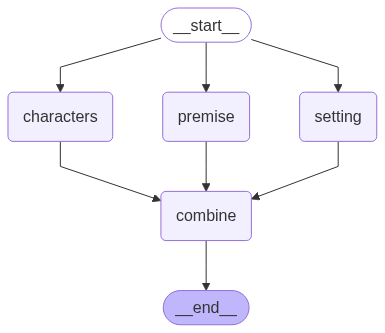

In [4]:
builder = StateGraph(State)
builder.add_node("characters", GenerateCharacters(llm))
builder.add_node("setting", GenerateSetting(llm))
builder.add_node("premise", GeneratePremise(llm))
builder.add_node("combine", CombineElements(llm))

builder.add_edge(START, "characters")
builder.add_edge(START, "setting")
builder.add_edge(START, "premise")
builder.add_edge("characters", "combine")
builder.add_edge("setting", "combine")
builder.add_edge("premise", "combine")
builder.add_edge("combine", END)

graph = builder.compile(checkpointer=MemorySaver())

display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
result = graph.invoke(dict(topic="Clive Rosfield survived and then..."), config={"configurable": {"thread_id": "1"}})

In [7]:
print(result.get("story"))

In the heart of the dense, whispering woods of Kent, where sunlight barely pierced through the thick canopy of oak trees, stood an ancient stone cottage, its weathered façade blending seamlessly into the landscape. The air was filled with the faint scent of damp earth and decaying leaves, mixed with a subtle fragrance from nearby wildflowers that had found their way through the cracks in the cobblestone path leading to the door.

Clive Rosfield emerged from the shadows of the forest, his footsteps barely audible on the carpet of fallen leaves. He was a man of about fifty, with sharp features softened by years under the harsh British sky, and eyes that held the weight of countless stories and secrets. His clothes were tattered but clean—evidence of recent washing—and he carried a rucksack slung over his shoulder, filled with essentials.

The cottage itself seemed to hold its breath as Clive approached. It was a modest structure, built from local stone and thatched roof, with large windo